In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [41]:
image = cv2.imread("x.jpg")
image = cv2.resize(image, (100, 80))

In [42]:
image.shape  #  HWC     C(3个通道)，OpenCV的顺序，是BGR

(80, 100, 3)

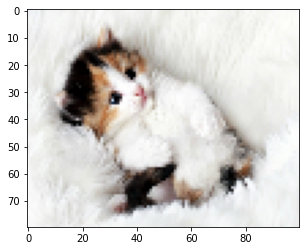

In [43]:
plt.imshow(image[..., ::-1])  #  plt.imshow，要求的格式是RGB的

In [44]:
# 高斯核
def gaussian_kernel2d(size, sigma):
    
    s = 2 * np.pi * sigma ** 2 # 我加了pi
    center = size // 2
    output = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            y = i - center
            x = j - center
            output[i, j] = np.exp(-(x ** 2 + y ** 2) / s)
    return output / np.sum(output)

In [45]:
kernel = gaussian_kernel2d(11, 1)

In [46]:
kernel.shape

(11, 11)

In [47]:
a, b, _ = image.shape
a, b

(80, 100)

In [54]:
kernel_height, kernel_width = kernel.shape
kernel_half_height, kernel_half_width = kernel_height // 2, kernel_width // 2
image_height, image_width, _ = image.shape
output_height = image_height - kernel_height + 1
output_width = image_width - kernel_width + 1
output = np.zeros((output_height, output_width, 3))

# x 和y ，是指的是当前卷积核的中心位置
for x in range(kernel_half_width, image_width - kernel_half_width):
    for y in range(kernel_half_height, image_height - kernel_half_height):
        for kx in range(kernel_width):
            for ky in range(kernel_height):
                # x = 1, y = 1, kx = 0, ky = 1
                # 当前卷积核的左上角位置的值
                kernel_value = kernel[ky, kx]  # 1, 0
                pixel_value = image[y - kernel_half_height + ky, x - kernel_half_width + kx] # 0, 0 
                output[y - kernel_half_height, x - kernel_half_width] += kernel_value * pixel_value # 1a + 2a

1. 乘法分散，效率很低
2. 优化，性能，所考虑的，是将计算密集，集中起来。尽可能利用矩阵乘法，因为矩阵乘法，被各个计算机科学家优化的很快很快

In [55]:
output.shape

(70, 90, 3)

In [56]:
np.min(output), np.max(output)

(4.008029500611286, 252.3294122257585)

In [57]:
output = (output - np.min(output)) / (np.max(output) - np.min(output))

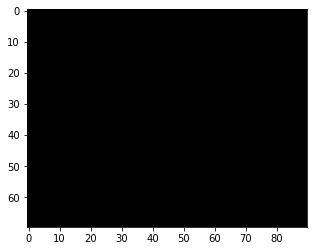

In [58]:
plt.imshow(output[..., ::-1] / 255)

In [59]:
output.dtype

dtype('float64')

* 卷积的实现：
    - 直接法，很典型，就是7个for，  -》  精度：没有损失
    - GEMM，矩阵乘法。通过把输入转换（im2col）为矩阵乘法形式，实现卷积，反向传播时，转换称之为（col2im）。       -》  精度：没有损失
    - FFT，快速傅里叶变换实现卷积    -》  精度：近似方法，有损失的
    - Winograd方法，针对特定卷积核大小时的计算优化, 3x3、5x5     -》  精度：没有损失，快速卷积方法
    - 其他方法，根据前面4种的改变变种实现